In [1]:
import numpy as np
import scipy as sp
import scipy.interpolate as interp
import sys,json,os
sys.path.append('../..')
import matplotlib.pyplot as plt
import Project.profiles as pp
import Project.new_profiles as pnp
import Project.plot_assist as pa
from Project.fit_line import Fitline as fl
import matplotlib
import matplotlib.cm as cm
import matplotlib.mlab as mlab
from tqdm.notebook import tqdm
import matplotlib.path as mpltPath
import math
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['mathtext.fontset'] = 'dejavuserif'

In [2]:
dmo = json.load(open('../../sim_RC_12/Output/resdicts/dmo_sim_dict.json','r'))
for gal in dmo:
    dmo[gal]['core_fit'] = dmo[gal]['sidm_fit']
    dmo[gal]['cusp_fit'] = dmo[gal]['nfw_fit']
bry = json.load(open('../../sim_RC_12/Output/resdicts/Bry_2sig_dict.json','r'))
bry_1 = json.load(open('../../sim_RC_12/Output/resdicts/Bry_1sig_dict.json','r'))
bry_p5 = json.load(open('../../sim_RC_12/Output/resdicts/Bry_p5sig_dict.json','r'))
# sparcd = json.load(open('../../obs_RC_v4/Output/result_dicts/sparc_fit_dict_comb.json','r'))
sparcd = json.load(open('../Output/sparc_new_dict.json','r'))

In [3]:
LM = np.zeros([15,15])
RN = np.zeros([15,15])
for lm_i in range(15):
    for rn_i in range(15):
        LM[lm_i,rn_i] = lm_i
        RN[lm_i,rn_i] = 14-rn_i
masses = np.array([9.0,9.3,9.6,9.9,10.2,10.5,10.8,11.1,11.4,11.7,12.0,12.3,12.6,12.9,13.2,13.5])
radius = np.array([0.2,0.4,0.6,0.8,1.0,1.4,1.8,2.2,2.6,3.0,3.4,3.8,4.2,4.6,5.0,5.4])
mass = 0.5*(masses[:-1]+masses[1:])
rad = 0.5*(radius[:-1]+radius[1:])
new_radius = [radius[-i-1] for i in range(len(radius))]
data = [[(1.,1.,1.) for i in range(16)] for i in range(16)]

lsig_edges = np.array([-2,-1,-0.5,0,0.5,1,1.5,2.,2.25,2.5,2.75,3.,3.5,4.,4.5,5])
lsigs = 0.5*(lsig_edges[:-1]+lsig_edges[1:])
LS = [[lsigs[i] for j in range(15)] for i in range(15)]
LS = np.array(LS)

LM_xi = sp.interpolate.interp1d(mass,np.arange(0,15,1),fill_value = (0,14),bounds_error = False)
RN_yi = sp.interpolate.interp1d(rad,np.arange(14,-1,-1),fill_value = (14,0),bounds_error = False)
LS_xi = sp.interpolate.interp1d(lsigs,np.arange(0,15,1),fill_value = (0,14),bounds_error = False)
LS_yi = sp.interpolate.interp1d(lsigs,np.arange(14,-1,-1),fill_value = (14,0),bounds_error = False)

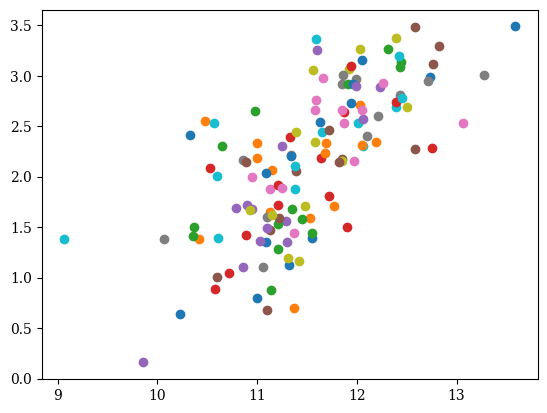

In [4]:
prior = 'lcdm_reg'
lmi_sparc,lsi_sparc,rni_sparc = [],[],[]
lmip_sparc,lsip_sparc,rnip_sparc = [],[],[]
lmim_sparc,lsim_sparc,rnim_sparc = [],[],[]
lbf_sparc = []
Sgals = []
for gal in sparcd[prior]:
    Sgals.append(gal)
    bestfit = sparcd[prior][gal]['best_fit']
    gald = sparcd[prior][gal][bestfit]
    lm = gald['lm']
    lmstar = gald['lmstar']
    rdstar = gald['rdstar']
    rn = sparcd[prior][gal]['rlast']/gald['rs'][0]
    rnp = sparcd[prior][gal]['rlast']/(gald['rs'][0]-gald['rs'][1])
    rnm = sparcd[prior][gal]['rlast']/(gald['rs'][0]+gald['rs'][1])
    if rnp < rn:
        rnp = rn
    if rnm > rn:
        rnm = rn
    ls = np.log10(pp.sig_exp(lmstar[0],rdstar[0])) - 6
    lsp = np.log10(pp.sig_exp(lmstar[0]+lmstar[1],rdstar[0]-rdstar[1])) - 6
    lsm = np.log10(pp.sig_exp(lmstar[0]-lmstar[1],rdstar[0]+rdstar[1])) - 6
    lmi_sparc.append(LM_xi(lm[0]))
    lsi_sparc.append(LS_xi(ls))
    rni_sparc.append(RN_yi(rn))
    lmip_sparc.append(LM_xi(lm[0]+lm[1]))
    lsip_sparc.append(LS_xi(lsp))
    rnip_sparc.append(RN_yi(rnm))
    lmim_sparc.append(LM_xi(lm[0]-lm[1]))
    lsim_sparc.append(LS_xi(lsm))
    rnim_sparc.append(RN_yi(rnp))
    lbf_sparc.append(sparcd[prior][gal]['core_fit']['lnZ']-sparcd[prior][gal]['cusp_fit']['lnZ'])
    plt.scatter(lm[0],ls)
lmi_sparc,lsi_sparc,rni_sparc = np.array(lmi_sparc),np.array(lsi_sparc),np.array(rni_sparc)
lmip_sparc,lsip_sparc,rnip_sparc = np.array(lmip_sparc),np.array(lsip_sparc),np.array(rnip_sparc)
lmim_sparc,lsim_sparc,rnim_sparc = np.array(lmim_sparc),np.array(lsim_sparc),np.array(rnim_sparc)
lmi_err = np.array([lmi_sparc-lmim_sparc,lmip_sparc-lmi_sparc])
lsi_err = np.array([lsi_sparc-lsim_sparc,lsip_sparc-lsi_sparc])
rni_err = np.array([rni_sparc-rnim_sparc,rnip_sparc-rni_sparc])

In [6]:
def get_axes(wspace = 0.2,xkey = ['lm','lm'], ykey = ['rn','rn'], title = True):
    fig,axs = plt.subplots(1,2, figsize = (10,5),gridspec_kw = {'wspace':wspace})
    for i in range(2):
        ax = axs[i]
        ax.imshow(data, alpha = 0.)
        ax.set_xticks(np.arange(-0.5,15.5,1))
        if xkey[i] == 'ls':
            ax.set_xticklabels(lsig_edges,rotation = 45)
        else:
            ax.set_xticklabels(masses,rotation = 45)
        ax.set_yticks(np.arange(-0.5,15.5,1))
        if ykey[i] == 'ls':
            ax.set_yticklabels([lsig_edges[-i - 1] for i in range(len(lsig_edges))])
        else:
            ax.set_yticklabels(new_radius)
        ax.tick_params(axis = 'both',direction = 'in',right = True,top = True, width = 1,length = 4)
        ax.grid(ls = '-',color = 'grey',alpha = 0.2)
        if xkey[i] == 'ls':
            ax.set_xlabel('log($\Sigma_0\,/\,\mathrm{M_{\odot}\,pc^{-2}}$)',size = 13,labelpad = 0)
        else:
            ax.set_xlabel('log($\mathrm{M_{200}/M_{\odot}}$)',size = 13,labelpad = 0)
        if ykey[i] == 'ls':
            ax.set_ylabel('log($\Sigma_0\,/\,\mathrm{M_{\odot}\,pc^{-2}}$)',size = 13,labelpad = 0)
        else:
            ax.set_ylabel('$r_{\:\mathrm{last}}\:/\:r_s$',size = 15,labelpad = 0)
        ax.set_ylim(14.5,-0.5)
        ax.set_xlim(-0.5,14.5)
        if title:
            axs[0].set_title('Input: CUSP', color = pa.green)
            axs[1].set_title('Input: CORE', color = pa.purple)
    return fig,axs[0],axs[1]
Clr = lambda clr,l,r = 0.2: [clr[r*(+1)] for i in range(l)]

In [7]:
def Zsmooth(oriX,oriY,oriZ,dN):
    X,Y,Z = oriX.copy(),oriY.copy(),oriZ.copy()
    X2,Y2,Z2 = X[::dN,::dN],Y[::dN,::dN],Z[::dN,::dN]
    Z_smooth =  interp.griddata(np.array([X2.ravel(),Y2.ravel()]).T,Z2.ravel(),(X,Y),method='cubic')
    return Z_smooth
def Delsmall(cn,diametercutoff = 4):
    for level in cn.collections:
        for kp,path in reversed(list(enumerate(level.get_paths()))):
            verts = path.vertices
            diameter = np.max(verts.max(axis = 0) - verts.min(axis = 0))

            if diameter < diametercutoff:
                del(level.get_paths()[kp])
    return cn

In [8]:
rels = json.load(open('../Output/reliabilities.json','r'))

In [9]:
relcc = np.array(rels['Relcc_ls'])
relhp = np.array(rels['Relhp_1'])
relcp = np.array(rels['Relcp_1'])

In [10]:
fig,ax1,ax2 = get_axes(0.3,title = False,xkey = ['ls','lm'])
axs = [ax1,ax2]
cmap = plt.get_cmap('Greys')

ax1.contourf(LM,RN,relcc,cmap = cmap, levels = [0.5,0.66,0.75,1])
cn1 = ax1.contour(LM,RN,relcc,colors = 'k',levels = [0.5,0.66,0.75,1])
cn1 = Delsmall(cn1,6)

ax2.contourf(LM,RN,relhp,cmap = cmap,levels = [0.5,0.66,0.75,1])
cn2 = ax2.contour(LM,RN,relhp,colors = 'k',levels = [0.5,0.66,0.75,1])
cn2 = Delsmall(cn2,6)
plt.clf()
    
def get_samplesaxes(clrs = None,alpha = 0.6,wspace = 0.3):
    fig,ax1,ax2 = get_axes(wspace,title = False,xkey = ['ls','lm'])
    cns = [cn1,cn2]
    axs = [ax1,ax2]
    if not clrs:
        clrs = [(0.33*i,0.33*i,0.33*i) for i in [3,2,1]]
        clrs = [(x,x,x) for x in [0.8,0.7,0.5]]
    for i in range(2):
        ax = axs[i]
        cn = cns[i]
        for j in range(len(cn.collections)):
            cnp = cn.collections[j].get_paths()
            for k in range(len(cnp)):
                p = cnp[k]
                v = p.vertices
                x,y = v[:,0],v[:,1]
                ax.plot(x,y,c = 'k')
                if i == 0:
                    ax.fill_betweenx(y,x,np.ones(len(x))*0,color = clrs[j],alpha = alpha)
                if i == 1 and j == 2:
                    ax.fill_betweenx(y,x,np.ones(len(y))*14,color = clrs[j],alpha = alpha)
                if i == 1 and j == 0:
                    ax.fill_between(x,y,np.ones(len(y))*0,color = clrs[j],alpha = alpha)
            if i == 1 and j == 1:
                p1,p2 = cnp
                v1,v2 = p1.vertices,p2.vertices
                x1,y1 = v1[:,0],v1[:,1]
                x1 = np.concatenate([x1,[14]])
                y1 = np.concatenate([y1,[0]])
                x2,y2 = v2[:,0],v2[:,1]
                x2 = np.concatenate([[14],x2])
                y2 = np.concatenate([[y2[-1]],y2])
                xf = np.concatenate([x1,x2])
                yf = np.concatenate([y1,y2])
                ax.fill(xf,yf, color = clrs[j],alpha = 0.6)
                
    return fig,ax1,ax2

<Figure size 1000x500 with 0 Axes>

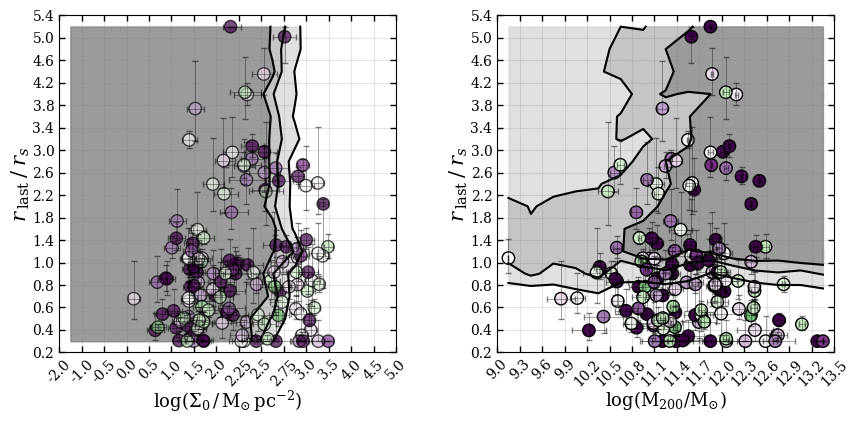

In [11]:
fig,ax1,ax2 = get_samplesaxes()
ax1.errorbar(lsi_sparc,rni_sparc,xerr = lsi_err, yerr = rni_err, fmt = '.', ecolor = 'k',
         capsize = 2,elinewidth = 0.5, alpha = 0.5,color = 'none')
sc = ax1.scatter(lsi_sparc,rni_sparc,cmap = pa.prgn_r, c = lbf_sparc, marker = 'o',
        s = 80,vmin = -5, vmax = 5, edgecolor = 'k',alpha = 0.7)
    
ax2.errorbar(lmi_sparc,rni_sparc,xerr = lmi_err, yerr = rni_err, fmt = '.', ecolor = 'k',
             capsize = 2,elinewidth = 0.5, alpha = 0.5,color = 'none')
ax2.scatter(lmi_sparc,rni_sparc,cmap = pa.prgn_r, c = lbf_sparc, marker = 'o',
            s = 80,vmin = -5, vmax = 5, edgecolor = 'k')

# Getting reliable samples of cusp-core distinction

13 54 22


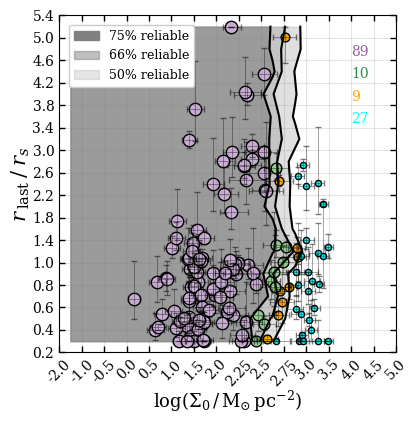

In [12]:
fig,ax1,ax2 = get_samplesaxes()
ax2.remove()
from matplotlib.patches import Polygon

polygons = []
for i in range(3):
    path = cn1.collections[i].get_paths()[0]
    v = path.vertices
    x,y = v[:,0],v[:,1]
    
    polygon = [[x[i],y[i]] for i in range(len(x))]
    polygon.append([0,14])
    polygon.append([0,0])
    polygon = np.array(polygon)
    polygons.append(polygon)
    
path75 = mpltPath.Path(polygons[2])
path66 = mpltPath.Path(polygons[1])
path50 = mpltPath.Path(polygons[0])

CC_75_gals = []
CC_66_gals = []
CC_50_gals = []
CC_00_gals = []
for i in range(len(Sgals)):
    ls = lsi_sparc[i]
    rn = rni_sparc[i]
    els = np.array([lsi_err[:,i]]).T
    ern = np.array([rni_err[:,i]]).T
    inside_75 = path75.contains_point((ls,rn),radius = 0.01)
    inside_66 = path66.contains_point((ls,rn),radius = 0.01)
    inside_50 = path50.contains_point((ls,rn),radius = 0.01)
    ax1.errorbar(ls,rn,xerr=els,yerr=ern,fmt='.',ecolor = 'k',capsize = 2,alpha = 0.5,color = 'none',elinewidth = 0.5)
    if inside_75:
        CC_75_gals.append(Sgals[i])
        ax1.scatter(ls,rn,marker = 'o',s=80,edgecolor = 'k',color = pa.pr(0.3))
    elif inside_66:
        CC_66_gals.append(Sgals[i])
        ax1.scatter(ls,rn,marker = 'o',s=60,edgecolor = 'k',color = pa.gn(0.6))
    elif inside_50:
        CC_50_gals.append(Sgals[i])
        ax1.scatter(ls,rn,marker = 'o',s=40,edgecolor = 'k',color = 'orange')
    else:
        CC_00_gals.append(Sgals[i])
        ax1.scatter(ls,rn,marker = '.',s=80,edgecolor = 'k',color = 'cyan')
        
ax1.text(12.5,1.3,'%i'%len(CC_75_gals), color = pa.pr(0.6))       
ax1.text(12.5,2.3,'%i'%len(CC_66_gals), color = pa.gn(0.3))
ax1.text(12.5,3.3,'%i'%len(CC_50_gals), color = 'orange')
ax1.text(12.5,4.3,'%i'%len(CC_00_gals), color = 'cyan')

cusp_cnt,core_cnt,indr_cnt = 0,0,0
for gal in CC_75_gals:
    lbf = sparcd[prior][gal]['delta_lnZ']
    if lbf < -1:
        cusp_cnt += 1
    elif lbf > 1:
        core_cnt += 1
    elif np.abs(lbf) < 1:
        indr_cnt += 1
print (cusp_cnt,core_cnt,indr_cnt)

ax1.fill_between([-1e10,-1e10],[-1e10,-1e10],[-1e10,-1e10],color = 'grey', label = '75% reliable')
ax1.fill_between([-1e10,-1e10],[-1e10,-1e10],[-1e10,-1e10],color = 'grey', label = '66% reliable',alpha = 0.5)
ax1.fill_between([-1e10,-1e10],[-1e10,-1e10],[-1e10,-1e10],color = 'grey', label = '50% reliable',alpha = 0.2)
ax1.legend(loc = 'upper left',bbox_to_anchor = (0.01,0.99),framealpha = 1,prop = {'size':9})

# plt.savefig('../Output/reliability/Sparc_cusp_core_distinction_reliability.pdf',bbox_inches = 'tight',dpi = 300)

# Getting reliable samples of halo parameters estimation

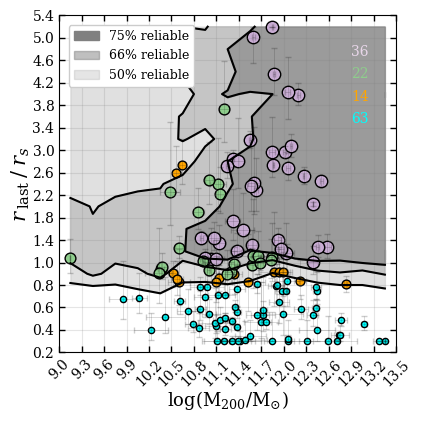

In [13]:
fig,ax1,ax2 = get_samplesaxes()
ax1.remove()

polygons = []
for i in range(3):
    if i == 0:
        path = cn2.collections[i].get_paths()[0]
        v = path.vertices
        x,y = v[:,0],v[:,1]
        polygon = [[x[i],y[i]] for i in range(len(x))]
        polygon.append([0,0])
        polygon.append([14,0])
    elif i == 1:
        path1 = cn2.collections[i].get_paths()[0]
        path2 = cn2.collections[i].get_paths()[1]
        v1,v2 = path1.vertices,path2.vertices
        x1,y1,x2,y2 = v1[:,0],v1[:,1],v2[:,0],v2[:,1]
        polygon = [[x2[i],y2[i]] for i in range(len(x2))]
        [polygon.append([x1[i],y1[i]]) for i in range(len(x1))]
        polygon.append([14,0])
    elif i == 2:
        path = cn2.collections[2].get_paths()[0]
        v = path.vertices
        x,y = v[:,0],v[:,1]
        polygon = [[x[i],y[i]] for i in range(len(x))]
        polygon.append([14,0])
    polygon = np.array(polygon)
    polygons.append(polygon)
    
path75 = mpltPath.Path(polygons[2])
path66 = mpltPath.Path(polygons[1])
path50 = mpltPath.Path(polygons[0])

HP_75_gals = []
HP_66_gals = []
HP_50_gals = []
HP_00_gals = []
for i in range(len(Sgals)):
    lm = lmi_sparc[i]
    rn = rni_sparc[i]
    elm = np.array([lmi_err[:,i]]).T
    ern = np.array([rni_err[:,i]]).T
    inside_75 = path75.contains_point((lm,rn),radius = 0.3)
    inside_66 = path66.contains_point((lm,rn),radius = 0.3)
    inside_50 = path50.contains_point((lm,rn),radius = 0.3)
    ax2.errorbar(lm,rn,xerr=elm,yerr=ern,fmt='.',ecolor = 'k',capsize = 2,alpha = 0.2,color = 'none',elinewidth = 0.5)
    if inside_75:
        HP_75_gals.append(Sgals[i])
        ax2.scatter(lm,rn,marker = 'o',s=80,edgecolor = 'k',color = pa.pr(0.3))
    elif inside_66:
        HP_66_gals.append(Sgals[i])
        ax2.scatter(lm,rn,marker = 'o',s=60,edgecolor = 'k',color = pa.gn(0.6))
    elif inside_50:
        HP_50_gals.append(Sgals[i])
        ax2.scatter(lm,rn,marker = 'o',s=40,edgecolor = 'k',color = 'orange')
    else:
        HP_00_gals.append(Sgals[i])
        ax2.scatter(lm,rn,marker = '.',s=80,edgecolor = 'k',color = 'cyan')
        
ax2.text(12.5,1.3,'%i'%len(HP_75_gals), color = pa.pr(0.1))       
ax2.text(12.5,2.3,'%i'%len(HP_66_gals), color = pa.gn(0.6))
ax2.text(12.5,3.3,'%i'%len(HP_50_gals), color = 'orange')
ax2.text(12.5,4.3,'%i'%len(HP_00_gals), color = 'cyan')

ax2.fill_between([-1e10,-1e10],[-1e10,-1e10],[-1e10,-1e10],color = 'grey', label = '75% reliable')
ax2.fill_between([-1e10,-1e10],[-1e10,-1e10],[-1e10,-1e10],color = 'grey', label = '66% reliable',alpha = 0.5)
ax2.fill_between([-1e10,-1e10],[-1e10,-1e10],[-1e10,-1e10],color = 'grey', label = '50% reliable',alpha = 0.2)
ax2.legend(loc = 'upper left',bbox_to_anchor = (0.01,0.99),framealpha = 1,prop = {'size':9})

# plt.savefig('../Output/reliability/Sparc_halo_params_reliability.pdf',bbox_inches = 'tight',dpi = 300)

In [14]:
LSi_sparc,LMi_sparc,RNi_sparc = {},{},{}
LSi_err,LMi_err,RNi_err = {},{},{}
for i in range(len(Sgals)):
    LSi_sparc[Sgals[i]] = lsi_sparc[i]
    LMi_sparc[Sgals[i]] = lmi_sparc[i]
    RNi_sparc[Sgals[i]] = rni_sparc[i]
    LSi_err[Sgals[i]] = np.array([lsi_err[:,i]]).T
    LMi_err[Sgals[i]] = np.array([lmi_err[:,i]]).T
    RNi_err[Sgals[i]] = np.array([rni_err[:,i]]).T

21 23 15


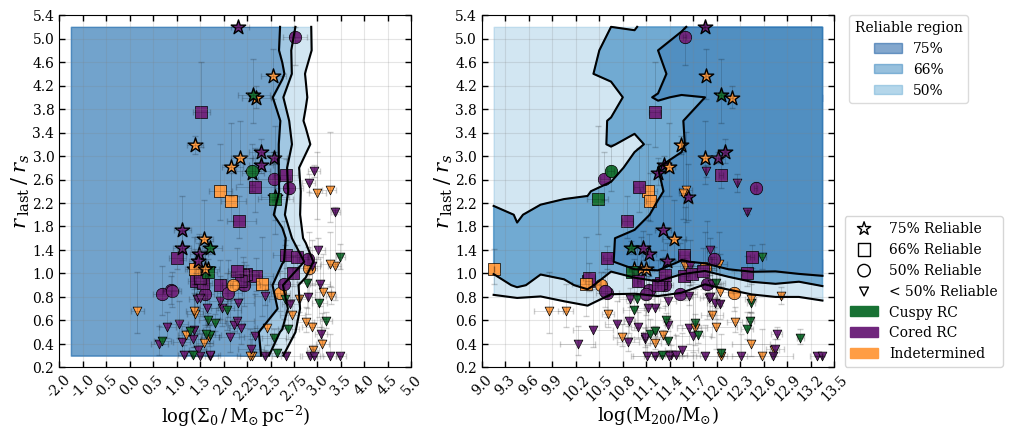

In [33]:
# clrs = [[1, 214/255., 122/255.],[1, 157/255., 68/255.],[1, 133/255., 51/255.]]
clrs = [[107/255.,174/255.,214/255.],[49/255.,130/255.,189/255.],[8/255.,81/255.,156/255.]]
# clrs = [[65/255.,182/255.,196/255.],[44/255.,127/255.,184/255.],[37/255.,52/255.,148/255.]]
blue = plt.get_cmap('GnBu')(0.7)
blue = [1, 157/255., 68/255.]

fig,ax1,ax2 = get_samplesaxes(clrs = clrs,alpha = 0.3,wspace = 0.2)
cnt_75,cnt_66,cnt_50 = 0,0,0
Bestgals_75,Bestgals_66,Bestgals_50 = [],[],[]
for gal in Sgals:
    lbf = sparcd[prior][gal]['delta_lnZ']
    clr = pa.gn(0.2) if lbf < 0 else pa.pr(0.8)
    if np.abs(lbf) < 1:
        clr = blue
    if (gal in CC_75_gals) and (gal in HP_75_gals):
        Bestgals_75.append(gal)
        cnt_75 += 1
        s,lw = 120,1
        m = '*'
    elif gal in (np.concatenate((CC_75_gals,CC_66_gals))) and (gal in np.concatenate((HP_75_gals,HP_66_gals))):
        Bestgals_66.append(gal)
        cnt_66 += 1
        s,lw = 80,0.5
        m = 's'
    elif (gal in np.concatenate((CC_75_gals,CC_66_gals,CC_50_gals))) and (gal in np.concatenate((HP_75_gals,HP_66_gals,HP_50_gals))):
        Bestgals_50.append(gal)
        cnt_50 += 1
        s,lw = 80,0.5
        m = 'o'
    else:
        s,lw = 40,0.5
        m = 'v'
        
    # if gal == 'UGCA444':
    #     ax1.text(LSi_sparc[gal],RNi_sparc[gal],gal)
    ax1.scatter(LSi_sparc[gal],RNi_sparc[gal],color = clr,s = s,edgecolor = 'k',lw = lw,marker = m)
    ax2.scatter(LMi_sparc[gal],RNi_sparc[gal],color = clr,s = s,edgecolor = 'k',lw = lw,marker = m)
    ax1.errorbar(LSi_sparc[gal],RNi_sparc[gal],xerr=LSi_err[gal],yerr=RNi_err[gal],fmt='.',ecolor = 'k',capsize = 2,alpha = 0.2,color = 'none',elinewidth = 0.5)
    ax2.errorbar(LMi_sparc[gal],RNi_sparc[gal],xerr=LMi_err[gal],yerr=RNi_err[gal],fmt='.',ecolor = 'k',capsize = 2,alpha = 0.2,color = 'none',elinewidth = 0.5)
    # if gal == 'NGC5371':
    #     ax2.text(LSi_sparc[gal],RNi_sparc[gal],gal)
    
ax1.fill_between([-1e10,-1e10],[-1e10,-1e10],[-1e10,-1e10],color = clrs[2], label = '75%',alpha = 0.5)
ax1.fill_between([-1e10,-1e10],[-1e10,-1e10],[-1e10,-1e10],color = clrs[1], label = '66%',alpha = 0.5)
ax1.fill_between([-1e10,-1e10],[-1e10,-1e10],[-1e10,-1e10],color = clrs[0], label = '50%',alpha = 0.5)
ax1.legend(bbox_to_anchor = (2.6,1.02), prop = {'size':10},framealpha = 0.7,title = 'Reliable region')

ax2.scatter(-10,-10,marker = '*',s = 100,facecolor = 'None',edgecolor = 'k',label = '75% Reliable')
ax2.scatter(-10,-10,marker = 's',s = 80,facecolor = 'None',edgecolor = 'k',label = '66% Reliable')
ax2.scatter(-10,-10,marker = 'o',s = 80,facecolor = 'None',edgecolor = 'k',label = '50% Reliable')
ax2.scatter(-10,-10,marker = 'v',s = 40,facecolor = 'None',edgecolor = 'k',label = '< 50% Reliable')
ax2.fill_between([-1e10,-1e10],[-1e10,-1e10],[-1e10,-1e10],color = pa.gn(0.2), label = 'Cuspy RC',alpha = 1)
ax2.fill_between([-1e10,-1e10],[-1e10,-1e10],[-1e10,-1e10],color = pa.pr(0.8), label = 'Cored RC',alpha = 1)
ax2.fill_between([-1e10,-1e10],[-1e10,-1e10],[-1e10,-1e10],color = blue, label = 'Indetermined',alpha = 1)
ax2.legend(bbox_to_anchor = (1.01,0.45))

# ax1.set_title('Reliability of cusp-core distinction',size = 10)
# ax2.set_title('Reliability of halo Parameters estimation',size = 10)
    
print (len(Bestgals_75),len(Bestgals_66),len(Bestgals_50))
    
# txt = 'star for 75% reliable (both cusp-core and \n halo parameters) square for 66% reliable, \n "o" for 50% reliable and "." for the rest. \n Purple for core, green for cups and orange \n for |lbf| < 1'
# ax2.text(16,5,txt);

plt.savefig('../Output/reliability/reliability_with_SPARC_included.pdf',bbox_inches = 'tight',dpi = 300)

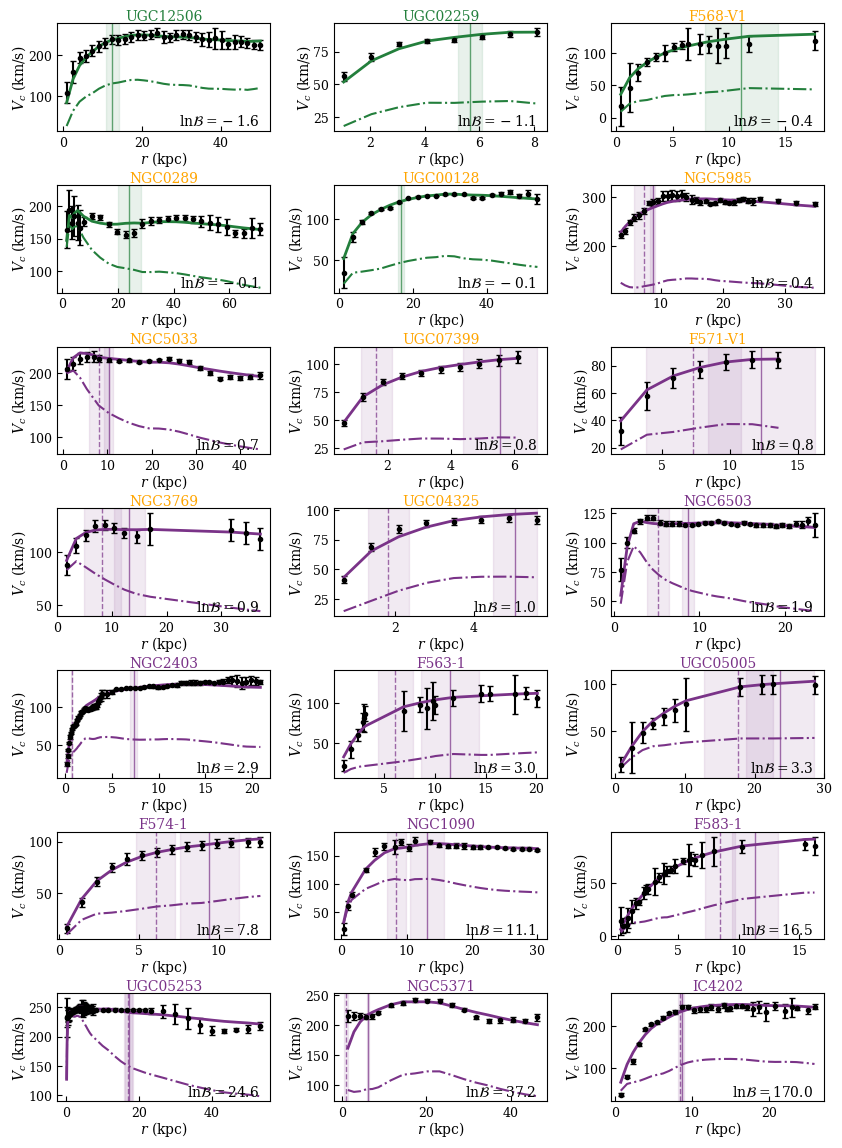

In [46]:
CF_level = '75'
if CF_level == '75':
    bestgals = Bestgals_75
elif CF_level == '66':
    bestgals = Bestgals_66
elif CF_level == '50':
    bestgals = Bestgals_50
    
l = math.ceil(len(bestgals)/3.)
fig, axs = plt.subplots(l,3,figsize = (3.3*3, 2*l),gridspec_kw = {'wspace':0.3,'hspace':0.5})
axs = axs.flatten()

for i in range(len(axs)):
    ax = axs[i]
    if i > len(bestgals)-1:
        ax.remove()

lbfs = []
for gal in bestgals:
    gald = sparcd[prior][gal]
    lbf = gald['delta_lnZ']
    lbfs.append(lbf)

bestgals = np.array(bestgals)
lbfs = np.array(lbfs)
inds = lbfs.argsort()
orderedbest = bestgals[inds]

orderedbest = [x for _,x in sorted(zip(lbfs,bestgals))]
fillx = lambda ax,x,y,clr: ax.fill_betweenx(y,x[0]-x[1],x[0]+x[1],color = clr,alpha = 0.1) 
prior = 'lcdm_reg'
for i in range(len(orderedbest)):
    gal = orderedbest[i]
    gald = sparcd[prior][gal]
    r = gald['r']
    vc = gald['vc']
    ve = gald['ve']
    vg = gald['vg']
    vs = gald['vd']
    lbf = gald['delta_lnZ']
    bestfit = gald['best_fit']
    vm = gald[bestfit]['vcmodel']
    vb = gald[bestfit]['vbary']
    clr = pa.gn(0.25) if bestfit == 'cusp_fit' else pa.pr_r(0.25)
    ax = axs[i]
    ax.errorbar(r,vc,ve, fmt = '.', color = 'k',capsize = 2)
    ax.plot(r,vm, color = clr,lw = 2)
    ax.plot(r,vb,color = clr,ls = '-.')
    ax.text(0.95,0.05,'$\mathrm{ln}\mathcal{B} = %.1f$'%lbf,transform = ax.transAxes,horizontalalignment = 'right',
            weight = 'bold')
    ylim = ax.get_ylim()
    xlim = ax.get_xlim()[1]
    rs_n = gald['cusp_fit']['rs']
    rs_c = gald['core_fit']['rs']
    rc = gald['core_fit']['r1']
    if bestfit == 'cusp_fit':
        if rs_n[0] < xlim:
            ax.plot([rs_n[0],rs_n[0]],ylim,color = pa.gn(0.25),lw = 1,ls = '-',alpha = 0.7)
            fillx(ax,rs_n,ylim,pa.gn(0.25))
    elif bestfit == 'core_fit':
        if rs_c[0] < xlim:
            ax.plot([rs_c[0],rs_c[0]],ylim,color = pa.pr_r(0.25),lw= 1,ls = '-',alpha = 0.7)
            fillx(ax,rs_c,ylim,pa.pr_r(0.25))
        if rc[0] < xlim:
            ax.plot([rc[0],rc[0]],ylim,color = pa.pr_r(0.25),lw = 1,ls = '--',alpha = 0.7)
            fillx(ax,rc,ylim,pa.pr_r(0.25))
    ax.set_ylim(ylim)
#     otherfit = 'core_fit' if bestfit == 'cusp_fit' else 'cusp_fit'
#     vm = gald[otherfit]['vcmodel']
#     clr = pa.gn(0.25) if otherfit == 'cusp_fit' else pa.pr_r(0.25)
#     ax.plot(r,vm,alpha = 1, lw = 1, color = clr)
    
    ax.tick_params(which = 'both', direction = 'in',labelsize = 9)
    ax.set_ylabel('$V_c$ (km/s)',size = 10,labelpad = 0.2)
    ax.set_xlabel('$r$ (kpc)',size = 10,labelpad = 0)
    clr = pa.gn(0.25) if bestfit == 'cusp_fit' else pa.pr_r(0.25)
    if np.abs(lbf) < 1:
        clr = 'orange'
        
    ax.set_title(gal,size = 10,pad = 0,color = clr)
    
plt.savefig('../Output/reliability/%s_reliable_SPARC_gals.pdf'%CF_level,bbox_inches = 'tight',dpi = 300)

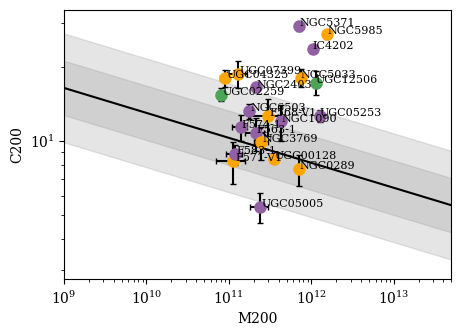

In [ ]:
fig,ax = plt.subplots(figsize = (5,3.5))
lm = np.linspace(9.,14, 10)
lc = pp.lc200_SR(lm)
ax.plot(10**lm,10**lc, c = 'k')
ax.fill_between(10**lm, 10**(lc+0.11), 10**(lc-0.11), color = 'grey', alpha = 0.2)
ax.fill_between(10**lm, 10**(lc+0.22), 10**(lc-0.22), color = 'grey', alpha = 0.2)

prior = 'lcdm_reg'
for gal in Bestgals_75:
    lbf = sparcd[prior][gal]['delta_lnZ']
    model = 'cusp_fit' if lbf < 0 else 'core_fit'
    gald = sparcd[prior][gal][model]
    m2,em2 = gald['m200']
    c2,ec2 = gald['c200']
    lm,elm = gald['lm']
    clr = pa.green if model == 'cusp_fit' else pa.purple
    if np.abs(lbf) < 1:
        clr = 'orange'
    ax.errorbar(m2,c2,xerr = em2, yerr = ec2, color = clr, ecolor = 'k', capsize = 2,fmt = 'o',ms = 8)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(1e9,5e13)
    # ax.set_ylim(4,30)
    ax.text(m2+5e9,c2,gal,color = 'k',size = 8)
    
# ax.set_yticks([4,6,8,10,20,30,40])
# ax.set_yticklabels([4,6,8,10,20,30,40])
ax.set_xlabel('M200',size = 10)
ax.set_ylabel('C200',size = 10);


# plt.savefig('../Output/reliability/M200_C200_relation_Bestgals.pdf',bbox_inches = 'tight',dpi = 300)

In [38]:
Bestgals = {'cc': {'75': CC_75_gals, '66': CC_66_gals, '50': CC_50_gals, '00': CC_00_gals},
            'hp': {'75': HP_75_gals, '66': HP_66_gals, '50': HP_50_gals, '00': HP_50_gals,},
            'cc_hp': {'75': Bestgals_75, '66': Bestgals_66, '50': Bestgals_50}}

In [19]:
json.dump(Bestgals, open('../Output/Bestgals.json','w'),indent = 2)

In [5]:
Bestgals = json.load(open('../Output/Bestgals.json','r'))
prior = 'lcdm_reg'

A mixture of the scatter and the absolue error in the data determines the final accuracy with which the underline parameters can be obtained. 

In [6]:
Bestgals = json.load(open('../Output/Bestgals.json','r'))
bestgals = Bestgals['cc_hp']['75']
bestgals = np.array(bestgals)
lbfs = np.array([sparcd[prior][gal]['delta_lnZ'] for gal in bestgals])
inds = lbfs.argsort()
bestgals = bestgals[inds]

In [70]:
from tabulate import tabulate
Details = []
cell = lambda a: '$%.2f \pm %.2f$'%(a[0],a[1])
for gal in bestgals:
    gdict = sparcd[prior][gal]
    lbf = gdict['delta_lnZ']
    bft = gdict['best_fit']
    for model in ['cusp','core']:
        fit = model + '_fit'
        gald = gdict[fit]
        r1data = cell(gald['r1']) if model == 'core' else '-'
        rsize = gdict['rlast']/gald['rs'][0]
        lsig = np.log10(pp.sig_exp(gald['lmstar'][0],gald['rdstar'][0])) - 6.
        LBF = np.around(lbf,2) if model == 'cusp' else ''
        LSIG = np.around(lsig,1) if model == bft[:4] else ''
        galaxy = gal if model == 'cusp' else '-'
        galdetails = [galaxy, model, LBF, cell(gald['lm']), cell(gald['c200']),r1data,
                      cell(gald['yd']), cell(gald['lmstar']),LSIG,rsize]
        Details.append(galdetails)
header  = ['Galaxy', 'Model', '$\lbf$', '$\lms$', '$c_{200}$', '$r_c$', '$\yd$', '$\lmstar$', '$\m{log}(\Sigma_0)$', r'$\rsize$']
table = tabulate(Details,tablefmt = 'latex_raw',floatfmt = '.2f',missingval = '-',headers = header )
print (table)    

\begin{tabular}{lllllllllr}
\hline
 Galaxy   & Model   & $\lbf$   & $\lms$           & $c_{200}$        & $r_c$            & $\yd$           & $\lmstar$        & $\m{log}(\Sigma_0)$   &   $\rsize$ \\
\hline
 UGC12506 & cusp    & -1.57    & $12.05 \pm 0.04$ & $17.24 \pm 1.90$ & -                & $0.54 \pm 0.10$ & $10.85 \pm 0.08$ & 2.3                   &       4.03 \\
 UGC12506 & core    &          & $12.05 \pm 0.04$ & $17.71 \pm 1.93$ & $2.10 \pm 1.62$  & $0.53 \pm 0.10$ & $10.84 \pm 0.08$ &                       &       4.16 \\
 UGC02259 & cusp    & -1.15    & $10.90 \pm 0.02$ & $15.42 \pm 0.90$ & -                & $0.52 \pm 0.12$ & $8.93 \pm 0.10$  & 1.7                   &       1.44 \\
 UGC02259 & core    &          & $10.90 \pm 0.02$ & $15.56 \pm 0.89$ & $0.92 \pm 0.53$  & $0.51 \pm 0.12$ & $8.92 \pm 0.10$  &                       &       1.45 \\
 F568-V1  & cusp    & -0.42    & $11.45 \pm 0.16$ & $12.59 \pm 2.14$ & -                & $0.54 \pm 0.12$ & $9.29 \pm 0.10$  & 1.6   

F568-V1 11.121543782018458 9.476139166806528
F571-V1 13.22682374253709 12.324910347921007
NGC0289 24.01617182949468 24.02146680661496
NGC3769 13.315400134785929 13.1950935682143
NGC5033 9.341546563778449 10.233206041285175
NGC5985 8.668659382789993 8.69799297203766
UGC00128 16.881447038036768 16.75141057003257
UGC04325 5.642009238587692 5.044624687126163
UGC07399 6.952546075055449 5.563591673002339


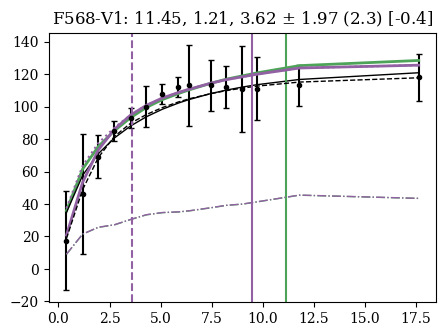

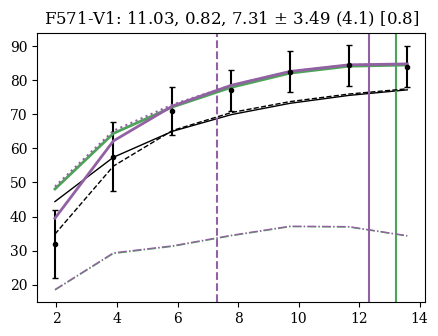

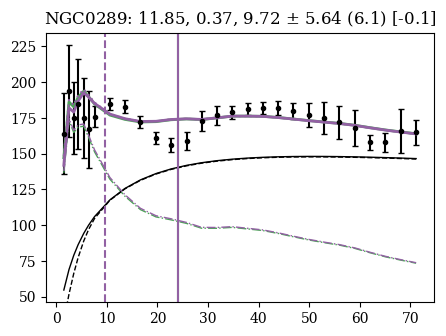

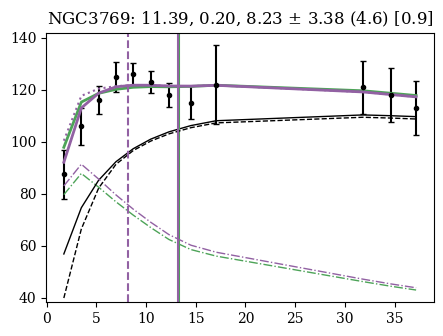

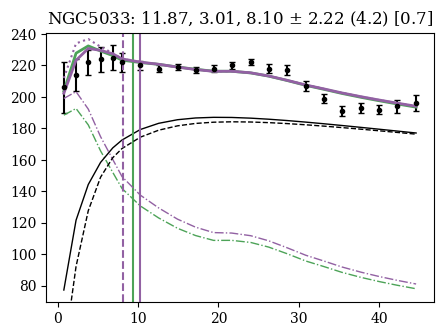

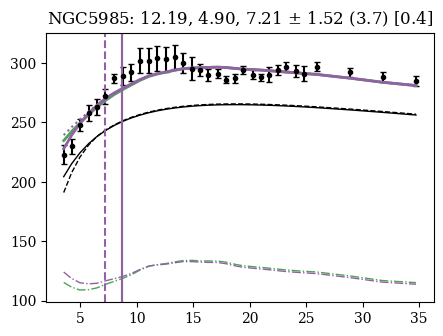

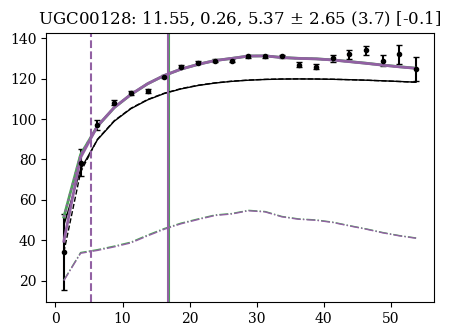

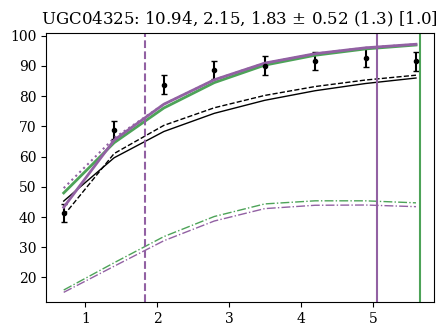

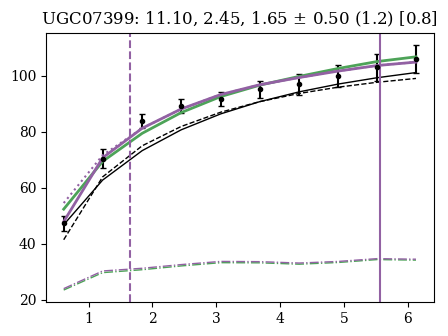

In [88]:

for rel in ['75']:
    for gal in Bestgals['cc_hp'][rel]:
        gdict = sparcd[prior][gal]
        lbf = gdict['delta_lnZ']
        bft = gdict['best_fit']
        gald = gdict[bft]
        if np.abs(lbf) < 1:
            fig,ax = plt.subplots(1,1,figsize = (5,3.5))
            pa.plot_RC(gal,sparcd,prior = 'lcdm_reg',ax = ax,DM = True)
            lm = gald['lm'][0]
            lc = pp.lc200_SR(lm)
            sigma = np.abs(lc - np.log10(gald['c200'][0]))/0.11
            ax.set_title('%s: %.2f, %.2f, %.2f $\pm$ %.2f (%.1f) [%.1f]'%(gal,lm,sigma,*gdict['core_fit']['r1'],gdict['core_fit']['rb'][0],lbf))
            r = np.array(gdict['r'])
            r = r[r <= gdict['core_fit']['r1'][0]]
            print (gal, gdict['cusp_fit']['rs'][0], gdict['core_fit']['rs'][0])
            # print (gal,np.log10(gald['rb'][0]))
            # print (gal,gald['rb'])

In [ ]:
fig,ax = pa.axs_MCR(nrow = 1,ncol = 1)
for rel in ['75','66','50']:
    for gal in Bestgals['cc_hp'][rel]

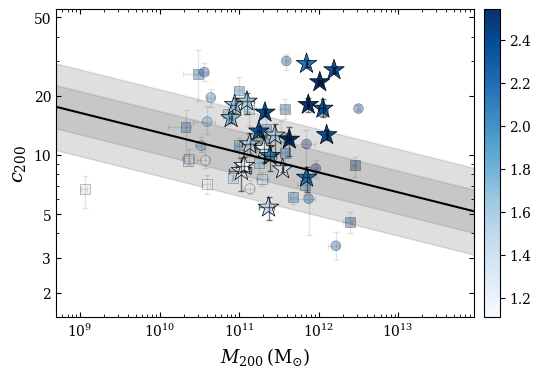

In [88]:
fig,ax = pa.axs_MCR(nrow = 1, ncol = 1,figsize = (6.5,4))
for rel in ['66','50','75']:
    x,y,c = [],[],[]
    for gal in Bestgals['cc_hp'][rel]:
        gdict = sparcd[prior][gal]
        lbf = gdict['delta_lnZ']
        bft = gdict['best_fit']
        gald = gdict[bft]
        ea = 0.5 if rel == '75' else 0.1
        pa.scatt_MCR(ax,gald['MCR'],clr = 'None',ealpha = ea)
        lsig = np.log10(pp.sig_exp(gald['lmstar'][0],gald['rdstar'][0])) - 6.
        x.append(gald['MCR'][0])
        y.append(gald['MCR'][1])
        c.append(lsig)
    if rel == '75':
        m,s,lw = '*',240,0.5
        a,ea = 1,0.5
    elif rel == '66':
        m,s,lw = 's',50,0.5
        a,ea = 0.35,0.1
    elif rel == '50':
        m,s,lw = 'o',50,0.5
        a,ea = 0.35,0.1
    sc = ax.scatter(x,y,c = c,cmap = plt.get_cmap('Blues'),marker = m, s = s, alpha = a, lw = lw, edgecolor = 'k')
cb = fig.colorbar(sc,ax = ax,pad = 0.02,label = '')

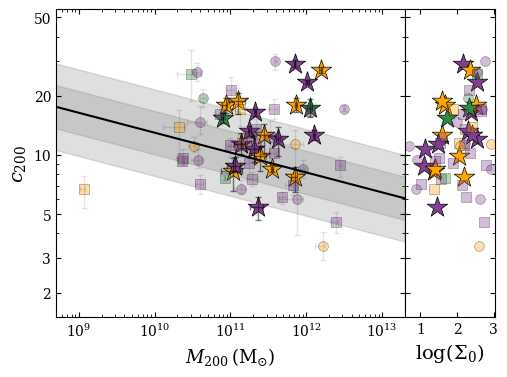

In [40]:
fig,ax = pa.axs_MCR(nrow = 1, ncol = 1,figsize = (4.5,4))
ax2 = fig.add_axes((0.9,0.11,0.2,0.77),sharey = ax)
# ax2.set_yticks([])
x,y,lsigs = [],[],[]
for rel in ['75','66','50']:
    for gal in Bestgals['cc_hp'][rel]:
        gdict = sparcd[prior][gal]
        lbf = gdict['delta_lnZ']
        bft = gdict['best_fit']
        gald = gdict[bft]
        if lbf < -1:
            clr = pa.gn(0.3)
        elif lbf > 1:
            clr = pa.pr(0.7)
        elif np.abs(lbf) < 1:
            clr = (0.65,0.65,0.65)
            clr = 'orange'
        mcr = gald['MCR']
        if rel == '75':
            mrk,s,lw = '*',240,0.5
            alpha,ealpha = 1,0.5
        elif rel == '66':
            mrk,s,lw = 's',50,0.5
            alpha,ealpha = 0.35,0.1
        elif rel == '50':
            mrk,s,lw = 'o',50,0.5
            alpha,ealpha = 0.35,0.1
        lsig = np.log10(pp.sig_exp(gald['lmstar'][0],gald['rdstar'][0])) - 6
        ax2.scatter(lsig,mcr[1],color = clr,marker = mrk,alpha = alpha,lw = lw, s = s,edgecolor = 'k')
        pa.scatt_MCR(ax,mcr,clr = clr,marker = mrk,lw = lw,edgecolor = 'k',s = s,elw = 1,ealpha = ealpha,alpha = alpha)
    
ax2.tick_params(axis = 'both', direction = 'in', which = 'both', right = True, top = True,labelleft = False)
# ax2.set_xlabel('$\mathrm{log}(\Sigma_0/[\mathrm{M_{\odot}\,kpc^{-2}}])$',size = 10)
ax2.set_xlabel('$\mathrm{log}(\Sigma_0)$',size = 14)

ax.set_xlim(5e8,2e13)

plt.savefig('../Output/reliability/MCR_bestgals.pdf',bbox_inches = 'tight',dpi = 300)

In [67]:
def get_mc(prior,gals):
    m2,em2,c2,ec2 = [],[],[],[]
    for gal in gals:
        bestfit = sparcd[prior][gal]['best_fit']
        mcr = sparcd[prior][gal][bestfit]['MCR']
        m2.append(mcr[0])
        c2.append(mcr[1])
        em2.append(np.mean(mcr[2]))
        ec2.append(np.mean(mcr[3]))
    m2 = np.array(m2)
    c2 = np.array(c2)
    em2 = np.array(em2)
    ec2 = np.array(ec2)
    return m2,c2,em2,ec2

line_fn = lambda x,m,c: m*x + c

print ('Flat reg')

m2,c2,em2,ec2 = get_mc('flat_reg',Bestgals_75)
line1 = sp.optimize.curve_fit(line_fn,np.log10(m2),np.log10(c2),
                              full_output = True,bounds = ([-np.inf,0],[0,np.inf]))
perr = np.sqrt(np.diag(line1[1]))
print (np.around(line1[0],3),np.around(perr,3))

m2,c2,em2,ec2 = get_mc('flat_reg',np.concatenate((Bestgals_75,Bestgals_66)))
line1 = sp.optimize.curve_fit(line_fn,np.log10(m2),np.log10(c2),
                              full_output = True,bounds = ([-np.inf,0],[0,np.inf]))
perr = np.sqrt(np.diag(line1[1]))
print (np.around(line1[0],3),np.around(perr,3))

m2,c2,em2,ec2 = get_mc('flat_reg',np.concatenate((Bestgals_75,Bestgals_66,Bestgals_50)))
line1 = sp.optimize.curve_fit(line_fn,np.log10(m2),np.log10(c2),
                              full_output = True,bounds = ([-np.inf,0],[0,np.inf]))
perr = np.sqrt(np.diag(line1[1]))
print (np.around(line1[0],3),np.around(perr,3))

m2,c2,em2,ec2 = get_mc('flat_reg',sparcd['flat_reg'].keys())
line1 = sp.optimize.curve_fit(line_fn,np.log10(m2),np.log10(c2),
                              full_output = True,bounds = ([-np.inf,0],[0,np.inf]))
perr = np.sqrt(np.diag(line1[1]))
print (np.around(line1[0],3),np.around(perr,3))

print ('LCDM reg')
m2,c2,em2,ec2 = get_mc('lcdm_reg',Bestgals_75)
line1 = sp.optimize.curve_fit(line_fn,np.log10(m2),np.log10(c2),
                              full_output = True,bounds = ([-np.inf,0],[0,np.inf]))
perr = np.sqrt(np.diag(line1[1]))
print (np.around(line1[0],3),np.around(perr,3))

m2,c2,em2,ec2 = get_mc('lcdm_reg',np.concatenate((Bestgals_75,Bestgals_66)))
line1 = sp.optimize.curve_fit(line_fn,np.log10(m2),np.log10(c2),
                              full_output = True,bounds = ([-np.inf,0],[0,np.inf]))
perr = np.sqrt(np.diag(line1[1]))
print (np.around(line1[0],3),np.around(perr,3))

m2,c2,em2,ec2 = get_mc('lcdm_reg',np.concatenate((Bestgals_75,Bestgals_66,Bestgals_50)))
line1 = sp.optimize.curve_fit(line_fn,np.log10(m2),np.log10(c2),
                              full_output = True,bounds = ([-np.inf,0],[0,np.inf]))
perr = np.sqrt(np.diag(line1[1]))
print (np.around(line1[0],3),np.around(perr,3))

m2,c2,em2,ec2 = get_mc('lcdm_reg',sparcd['lcdm_reg'].keys())
line1 = sp.optimize.curve_fit(line_fn,np.log10(m2),np.log10(c2),
                              full_output = True,bounds = ([-np.inf,0],[0,np.inf]))
perr = np.sqrt(np.diag(line1[1]))
print (np.around(line1[0],3),np.around(perr,3))

Flat reg
[-0.207  3.472] [0.109 1.257]
[-0.052  1.644] [0.065 0.743]
[-0.1    2.191] [0.056 0.639]
[-0.155  2.698] [0.036 0.421]
LCDM reg
[-0.     1.123] [0.105 1.212]
[-0.     1.075] [0.047 0.528]
[-0.01   1.184] [0.042 0.481]
[-0.11   2.191] [0.028 0.323]


In [54]:
def get_scat_MCR(m2,c2):
    lm = np.log10(m2)
    lc = np.log10(c2)
    lc_pred = pp.lc200_SR(lm)
    scatt = np.sqrt(((lc_pred - lc)**2).sum())/np.sqrt(len(m2)-1)
    return scatt
def get_scat_SHM(m2,ms):
    lm = np.log10(m2)
    ls = np.log10(ms)
    ls_pred = pnp.lmstar_behroozi_19(lm)
    scatt = np.sqrt(((ls_pred - ls)**2).sum())/np.sqrt(len(m2)-1)
    return scatt
    
def get_sigmas(gals):
    priors = ['flat_reg','lcdm_reg']
    sigmas = {'mcr':{},'shm':{}}
    for prior in priors:
        M2,C2,Ms = [],[],[]
        for gal in gals:
            bestfit = sparcd[prior][gal]['best_fit']
            gald = sparcd[prior][gal][bestfit]
            m2 = gald['m200'][0]
            c2 = gald['c200'][0]
            ms = gald['mstar'][0]
            M2.append(m2)
            C2.append(c2)
            Ms.append(ms)
        sigmas['mcr'][prior] = get_scat_MCR(np.array(M2),np.array(C2))
        sigmas['shm'][prior] = get_scat_SHM(np.array(M2),np.array(Ms))
    return sigmas

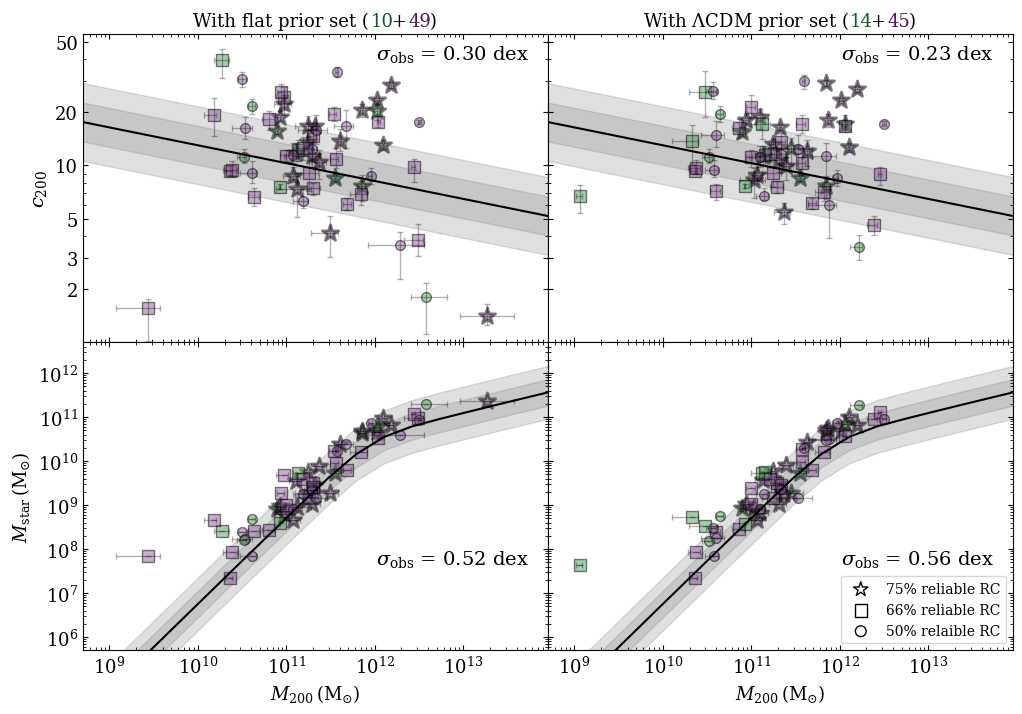

In [55]:
def plot_mc(gal,marker = 's',s = 120,lw = 1.5):
        bestfit = sparcd[prior][gal]['best_fit']
        if bestfit == 'cusp_fit':
            if prior == 'flat_reg':
                flat_cnt[0] += 1
            elif prior == 'lcdm_reg':
                lcdm_cnt[0] += 1
        else:
            if prior == 'flat_reg':
                flat_cnt[1] += 1
            elif prior == 'lcdm_reg':
                lcdm_cnt[1] += 1
        mcr = sparcd[prior][gal][bestfit]['MCR']
        shm = sparcd[prior][gal][bestfit]['SHM']
        
        # if sparcd[priors[0]][gal]['best_fit'] ==  sparcd[priors[1]][gal]['best_fit']:
        pa.scatt_MCR(ax_1,mcr,edgecolor = 'k',ealpha = 0.3,marker = marker,s = s,linewidth = lw)
        pa.scatt_SHM(ax_2,shm,edgecolor = 'k',ealpha = 0.3,marker = marker,s = s,linewidth = lw)
        # else:
            # pa.scatt_MCR(ax_1,mcr,marker = marker,alpha = 0.7,linewidth = 1.5, s = 120, 
                         # ealpha = 0.3, edgecolor = 'k')
            # pa.scatt_SHM(ax_2,shm,marker = marker,alpha = 0.7,linewidth = 1.5, s = 120, 
                         # ealpha = 0.3, edgecolor = 'k')

fig,axs = plt.subplots(2,2,figsize = (12,8),gridspec_kw = {'wspace':0,'hspace':0})
ax1,ax2 = axs
ax1 = pa.axs_MCR(axs = ax1)
ax2 = pa.axs_SHM(axs = ax2)
priors = ['flat_reg','lcdm_reg']
ax1[1].set_ylabel('')
ax2[1].set_ylabel('')
flat_cnt = [0,0]
lcdm_cnt = [0,0]
for ax_1,ax_2, prior in zip(ax1,ax2,priors):
    ax_1.tick_params(axis = 'both', labelsize = 13)
    ax_2.tick_params(axis = 'both', labelsize = 13)
    ax_1.set_xlabel('')
    ax_1.set_xticklabels([])
    ax_2.set_ylim(5e5,5e12)
    ax_1.set_ylim(1,ax_1.get_ylim()[1])
    for gal in Bestgals_75:
        plot_mc(gal,'*',s = 150,lw = 2)
    for gal in Bestgals_66:
        plot_mc(gal,'s',lw = 1,s = 80)
    for gal in Bestgals_50:
        plot_mc(gal,'o',lw = 1,s = 50)
        
# logx = np.linspace(8.,14)
# ax1[0].plot(10**logx,10**(line3[0][0]*logx + line3[0][1]), c = 'r')
# ax1[1].plot(10**logx,10**(line2[0][0]*logx + line2[0][1]), c = 'b')

ax1[1].tick_params(right = True)
ax1[1].set_yticklabels([])
ax2[1].tick_params(right = True)
ax2[1].set_yticklabels([])

sigmas = get_sigmas(np.concatenate((Bestgals_75,Bestgals_66,Bestgals_50)))
ax1[0].text(0.63,0.92,'$\sigma_{\mathrm{obs}}$ = %.2f dex'%(sigmas['mcr']['flat_reg']),transform = ax1[0].transAxes, size = 14)
ax1[1].text(0.63,0.92,'$\sigma_{\mathrm{obs}}$ = %.2f dex'%(sigmas['mcr']['lcdm_reg']),transform = ax1[1].transAxes, size = 14)
ax2[0].text(0.63,0.28,'$\sigma_{\mathrm{obs}}$ = %.2f dex'%(sigmas['shm']['flat_reg']),transform = ax2[0].transAxes, size = 14)
ax2[1].text(0.63,0.28,'$\sigma_{\mathrm{obs}}$ = %.2f dex'%(sigmas['shm']['lcdm_reg']),transform = ax2[1].transAxes, size = 14)

ax1[0].set_title('With flat prior set (    +    )',size = 13)
ax1[1].set_title('With $\Lambda$CDM prior set (    +    )',size = 13)
ax1[0].text(0.62, 1.028,flat_cnt[0], size = 13, color = pa.gn(0.1), transform = ax1[0].transAxes)
ax1[0].text(0.70, 1.028,flat_cnt[1], size = 13, color = pa.pr(0.9),transform = ax1[0].transAxes)
ax1[1].text(0.65, 1.028,lcdm_cnt[0], size = 13, color = pa.gn(0.1), transform = ax1[1].transAxes)
ax1[1].text(0.73, 1.028,lcdm_cnt[1], size = 13, color = pa.pr(0.9),transform = ax1[1].transAxes);

ax2[1].scatter(-100,-100, marker = '*', s = 120, color = 'None', edgecolor = 'k', label = '75% reliable RC')
ax2[1].scatter(-100,-100, marker = 's', s = 80, color = 'None', edgecolor = 'k', label = '66% reliable RC')
ax2[1].scatter(-100,-100, marker = 'o', s = 60, color = 'None', edgecolor = 'k', label = '50% relaible RC')
ax2[1].legend(loc = 'lower right')

plt.savefig('../Output/paper1/SPARC_fit_results_75_66_50_2.pdf',bbox_inches = 'tight',dpi = 300)

In [7]:
for rel in ['75','66','50']:
    cnt = 0
    bgals = []
    for gal in Bestgals['cc_hp'][rel]:
        sparcd[prior][gal]['bulge']
        if bulge:
            bgals.append(gal)
            cnt += 1
    print ()

4 ['IC4202', 'NGC5033', 'NGC5985', 'UGC05253']
3 ['UGC03580', 'UGC06614', 'UGC06786']
1 ['UGC03546']


# Find similar looking mock RCs to real RCs.

In [239]:
def get_bestgal(real_r,real_vc,real_ve,tol = 1,n = [-1]):
    goodgals = []
    for gal in bry:
        data = np.loadtxt('../../sim_RC_12/Output/Mock_gals/Bry_2sig_gals/%s.dat'%gal)
        r,vc = data[:,0],data[:,1]
        yescnt = 0
        for ni in n:
            if len(r) <= ni:
                continue
            if (real_r[ni] - tol <= r[ni]) and (r[ni] <= real_r[ni] + tol):
                if (real_vc[ni] - real_ve[ni] <= vc[ni]) and (vc[ni] <= real_vc[ni] + real_ve[ni]):
                    yescnt += 1
        if yescnt == len(n):
            goodgals.append(gal)
    if not goodgals:
        print ('There are no good mock RCs for this galaxy')

    return goodgals


In [295]:
prior = 'flat_reg'
gali = np.random.randint(low = 0, high = len(sparcd[prior].keys()))

real_gal = list(sparcd[prior].keys())[gali]
gald = sparcd[prior][real_gal]
real_r,real_vc,real_ve = gald['r'],gald['vc'],gald['ve']

In [298]:
print (real_gal)

ggs = get_bestgal(real_r,real_vc,real_ve,2,n = [-1,0,10])

print (ggs)

NGC2366
['4_2_S_gal_19', '4_3_S_gal_0', '4_3_S_gal_4', '4_3_S_gal_17', '4_3_S_gal_31', '4_3_S_gal_37', '4_4_S_gal_0', '4_4_S_gal_7', '4_4_S_gal_8', '4_4_S_gal_18', '4_4_S_gal_26', '4_4_S_gal_27', '4_4_S_gal_36', '4_4_S_gal_38', '4_4_S_gal_44', '4_5_S_gal_2', '4_5_S_gal_15', '4_5_S_gal_16', '4_5_S_gal_32', '4_5_S_gal_40', '4_5_S_gal_48']


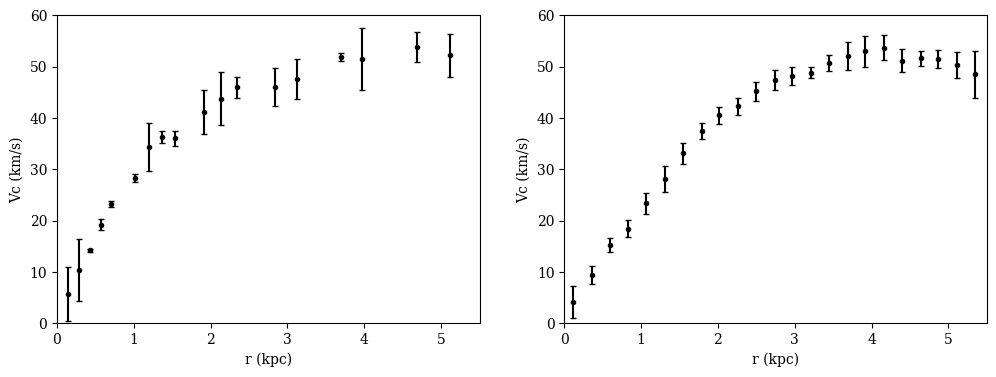

In [350]:
fig,axs = plt.subplots(1,2,figsize = (12,4))
ax1,ax2 = axs

# for gal in ggs:
for gal in [ggs[10]]:
    data = np.loadtxt('../../sim_RC_12/Output/Mock_gals/Bry_2sig_gals/%s.dat'%gal)
    ax1.errorbar(data[:,0],data[:,1],data[:,2],fmt = '.',label = gal,capsize = 2,color = 'k')
# ax1.legend()
ax2.errorbar(real_r,real_vc,real_ve,fmt = '.',color = 'k',capsize = 2)
# ax1.set_title(gal)
for ax in axs:
    ax.set_xlabel('r (kpc)')
    ax.set_ylabel('Vc (km/s)')
ax1.set_xlim([0,5.5])
ax1.set_ylim(0,60)
ax2.set_xlim(ax1.get_xlim())
ax2.set_ylim(ax1.get_ylim())
    
plt.savefig('../Output/presentation1/%s_%s_comp.png'%(real_gal,ggs[10]),bbox_inches = 'tight',dpi = 300)